In [1]:
# the discrete case

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def make_gmm(n_components=10, dim=2, seed=42,
             mean_range=(-5.0, 5.0), var_range=(0.05, 1.0),
             isotropic=True):
    """
    Build parameters for a Gaussian Mixture Model (GMM).

    - n_components: number of Gaussian centers (clusters)
    - dim: dimensionality (2 by default)
    - seed: RNG seed for reproducibility
    - mean_range: range for sampling means uniformly per dimension
    - var_range: range for sampling variances (sigma^2); used if isotropic=True
    - isotropic: if True, use scalar variance per component (sigma^2 * I).
                 if False, generate random full SPD covariances.

    Returns dict with keys: weights, means, covs, rng
    """
    rng = np.random.default_rng(seed)

    # Mixture weights (sum to 1)
    weights = rng.dirichlet(np.ones(n_components))

    # Means
    means = rng.uniform(mean_range[0], mean_range[1], size=(n_components, dim))

    # Covariances
    if isotropic:
        # One random variance per component (same across dimensions)
        variances = rng.uniform(var_range[0], var_range[1], size=n_components)
        covs = np.array([v * np.eye(dim) for v in variances])
    else:
        # Random full SPD covariances with average variance within var_range
        covs = []
        target_var = rng.uniform(var_range[0], var_range[1], size=n_components)
        for tvar in target_var:
            A = rng.normal(size=(dim, dim))
            C = A @ A.T + 1e-3 * np.eye(dim)  # SPD
            # Scale so average variance (trace/dim) matches tvar
            scale = tvar / (np.trace(C) / dim)
            covs.append(C * scale)
        covs = np.array(covs)

    return dict(weights=weights, means=means, covs=covs, rng=rng)

def sample_gmm(n_samples, weights, means, covs, rng=None):
    """
    Sample points from a GMM described by weights, means, covs.
    Returns (X, component_indices)
    """
    if rng is None:
        rng = np.random.default_rng()

    K = len(weights)
    dim = means.shape[1]

    # Choose component for each sample
    comps = rng.choice(K, size=n_samples, p=weights)

    # Draw samples
    X = np.empty((n_samples, dim))
    for k in range(K):
        idx = np.where(comps == k)[0]
        if idx.size > 0:
            X[idx] = rng.multivariate_normal(mean=means[k], cov=covs[k], size=idx.size)
    return X, comps

In [3]:
save_dataset = []

params = make_gmm(n_components=20, dim=2, seed=123, mean_range=(-6, 6), var_range=(0.2, 0.8), isotropic=True)
X, z = sample_gmm(n_samples=20000, **params)
train_data = X-X.min()
train_data = train_data/train_data.max()

save_dataset.append(train_data)

params = make_gmm(n_components=20, dim=2, seed=127, mean_range=(-6, 6), var_range=(0.2, 0.8), isotropic=True)
X, z = sample_gmm(n_samples=20000, **params)
train_data = X-X.min()
train_data = train_data/train_data.max()

save_dataset.append(train_data)

params = make_gmm(n_components=20, dim=2, seed=128, mean_range=(-6, 6), var_range=(0.2, 0.8), isotropic=True)
X, z = sample_gmm(n_samples=20000, **params)
train_data = X-X.min()
train_data = train_data/train_data.max()

save_dataset.append(train_data)

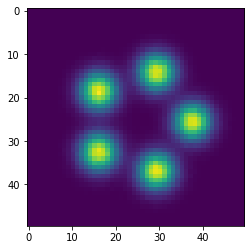

In [4]:
# Gaussian mixture 

import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()  # for plot styling

# Number of samples
n_samples = 1000000

# Define the circle radius and angle for the 5 Gaussian mixtures
radius = 10
angles = np.linspace(0, 2 * np.pi, 6)[:-1]  # exclude the last angle because it's the same as the first

# Initialize an empty array for the samples
samples = np.empty((0, 2))

# Define mixing proportions
mixing_proportions = [0.2, 0.2, 0.2, 0.2, 0.2]  # equal proportions

# Initialize variances for each Gaussian distribution
variances = np.linspace(6, 6, 5)

# Create Gaussian mixtures
for angle, proportion, variance in zip(angles, mixing_proportions, variances):
    # Compute the mean of the Gaussian
    mean = radius * np.array([np.cos(angle), np.sin(angle)])

    # Covariance matrix of the Gaussian (diagonal for independent components)
    cov_matrix = np.diag([variance, variance])

    # Generate samples from the Gaussian distribution
    samples_gaussian = np.random.multivariate_normal(mean, cov_matrix, size=int(n_samples * proportion))

    # Append the generated samples to the main samples array
    samples = np.vstack([samples, samples_gaussian])

X_train = samples
X_train = X_train-X_train.min()
X_train = X_train/X_train.max()

np.random.shuffle(X_train)

# plt.figure(figsize=(3, 3))
# # Plot the Gaussian mixture
# plt.scatter(X_train[::1, 0], X_train[::1, 1], color='blue', alpha=0.5, s=1)
# plt.show()

# Define the range for both axes
axis_range = [(0, 1), (0, 1)]

# Define the number of bins
bins = 50

# Calculate the 2D histogram and return the matrix of histogram values
hist, xedges, yedges = np.histogram2d(X_train[:, 0], X_train[:, 1], bins=bins, range=axis_range, density=True)

# Normalize the histogram to make it a PDF
pdf = hist / np.sum(hist)
pdf = torch.from_numpy(pdf.T)

plt.imshow(pdf)
plt.show()

save_dataset.append(X_train[::10])

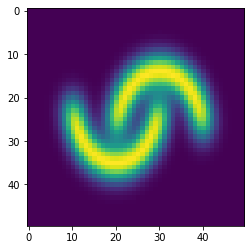

In [5]:
# two moon 

# producing matching results

# Neural Networks

X, y = make_moons(n_samples=100000000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train = X_train-X_train.min(0)
X_train = X_train/X_train.max(0)

# Define the range for both axes
axis_range = [(0, 1), (0, 1)]

# Define the number of bins
bins = 50

# Calculate the 2D histogram and return the matrix of histogram values
hist, xedges, yedges = np.histogram2d(X_train[:, 0], X_train[:, 1], bins=bins, range=axis_range, density=True)

# Normalize the histogram to make it a PDF
pdf = hist / np.sum(hist)
pdf = torch.from_numpy(pdf.T)

plt.imshow(pdf)
plt.show()

save_dataset.append(X_train[:100000])

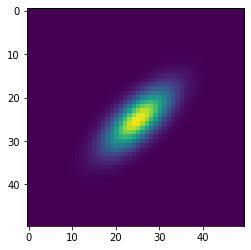

In [6]:
def generate_gaussian_data(n_samples=100000, mean=[0, 0], std_dev=[1, 1], rho=0):
    # Calculate the covariance using rho
    covariance = rho * std_dev[0] * std_dev[1]
    cov_matrix = [[std_dev[0]**2, covariance], [covariance, std_dev[1]**2]]
    
    # Sample from the multivariate Gaussian
    data = np.random.multivariate_normal(mean, cov_matrix, n_samples)
    data = data-data.min()
    data = data/data.max()

    return data

data = generate_gaussian_data(10000000, rho=-0.7)
data = data-data.mean(0)
data = data/data.max(0)
X_train = data

X_train = X_train-X_train.min()
X_train = X_train/X_train.max()

# plt.figure(figsize=(3, 3))
# plt.scatter(X_train[::1, 0], X_train[::1, 1], s=1, color='blue')
# plt.show()

# Define the range for both axes
axis_range = [(0, 1), (0, 1)]

# Define the number of bins
bins = 50

# Calculate the 2D histogram and return the matrix of histogram values
hist, xedges, yedges = np.histogram2d(X_train[:, 0], X_train[:, 1], bins=bins, range=axis_range, density=True)

# Normalize the histogram to make it a PDF
pdf = hist / np.sum(hist)
pdf = torch.from_numpy(pdf.T)

plt.imshow(pdf)
plt.show()

save_dataset.append(X_train[:100000])

In [7]:
def get_cost_nd():
    mean = decoded[:, :data_dim*center_dim].reshape(-1, center_dim, data_dim).permute(1, 0, 2)
    var = decoded[:, data_dim*center_dim:data_dim*center_dim*2].reshape(-1, center_dim, data_dim).permute(1, 0, 2)
    weights = decoded[:, data_dim*center_dim*2:data_dim*center_dim*2+center_dim].reshape(-1, center_dim, 1).permute(1, 0, 2).mean(-1)
    weight_multiple = weights.unsqueeze(1)*weights.unsqueeze(0)
    
    # decoder # difference for each sample
    L2 = ((mean.unsqueeze(1) - mean.unsqueeze(0))**2)
    L2_DATA = ((mean - batch_data.unsqueeze(0))**2)

    var_sum = (var.unsqueeze(1) + var.unsqueeze(0))
    var_data = var + var_noise
    #     var_data = var

    gauss_cross = torch.exp(-(L2/(2*var_sum)).sum(-1))
    gauss_cross = gauss_cross*(1/var_sum.prod(-1).sqrt())
#     gauss_cross = gauss_cross*(1/((2*np.pi)**(data_dim/2)))
#     gauss_cross = gauss_cross*(1/(2*np.pi*(var_sum.prod(-1).sqrt())))
#     gauss_cross = gauss_cross*(1/(((2*np.pi)**(data_dim/2))*var_sum.sqrt().prod(-1)))
    
    gauss_data = torch.exp(-(L2_DATA/(2*var_data)).sum(-1))
    gauss_data = gauss_data*(1/var_data.prod(-1).sqrt())
#     gauss_data = gauss_data*(1/((2*np.pi)**(data_dim/2)))

#     gauss_data = gauss_data*(1/(2*np.pi*(var_data.prod(-1).sqrt())))
#     gauss_data = gauss_data*(1/(((2*np.pi)**(data_dim/2))*var_data.sqrt().prod(-1)))

    gauss_cross = weight_multiple*gauss_cross
    gauss_data = weights*gauss_data

    numerator = gauss_data.mean()
    denominator = gauss_cross.mean()

    error = -(numerator**2)/(denominator)
#     error = error*(1/((2*np.pi)**(data_dim/2)))
    return error

class decoder(nn.Module):
    def __init__(self, input_dim = 784, HIDDEN = 2000, out_dim = 200):
        super(decoder, self).__init__()
        self.dim = out_dim
    
        self.fc1 = nn.Linear(input_dim+50, HIDDEN, bias=True)
#         self.fc1 = nn.Linear(input_dim, HIDDEN, bias=True)
        self.bn1 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc2 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn2 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc3 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn3 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc4 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn4 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc6 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn6 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc7 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn7 = torch.nn.BatchNorm1d(HIDDEN)

        self.fc8 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn8 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc9 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn9 = torch.nn.BatchNorm1d(HIDDEN)

        self.fc5 = nn.Linear(HIDDEN, out_dim, bias=True)

    def forward(self, x):
        
        x = torch.cat((x, torch.zeros((x.shape[0], 50)).uniform_().cuda()), 1)
        
        x = torch.relu(self.bn1((self.fc1(x))))
        x = torch.relu(self.bn2((self.fc2(x))))
        x = torch.relu(self.bn3((self.fc3(x))))
        x = torch.relu(self.bn4((self.fc4(x))))
        x = torch.relu(self.bn6((self.fc6(x))))
        x = torch.relu(self.bn7((self.fc7(x))))
        x = torch.relu(self.bn8((self.fc8(x))))
        x = torch.relu(self.bn9((self.fc9(x))))

        x = torch.sigmoid(self.fc5(x))

        return x
    
class encoder(nn.Module):
    def __init__(self, input_dim = 784, HIDDEN = 2000, out_dim = 200):
        super(encoder, self).__init__()
        self.dim = out_dim
    
        self.fc1 = nn.Linear(input_dim+50, HIDDEN, bias=True)
#         self.fc1 = nn.Linear(input_dim, HIDDEN, bias=True)
        self.bn1 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc2 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn2 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc3 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn3 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc4 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn4 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc6 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn6 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc7 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn7 = torch.nn.BatchNorm1d(HIDDEN)
        
        self.fc8 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn8 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc9 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn9 = torch.nn.BatchNorm1d(HIDDEN)

        self.fc5 = nn.Linear(HIDDEN, out_dim, bias=True)

    def forward(self, x):
        
        x = torch.cat((x, torch.zeros((x.shape[0], 50)).uniform_().cuda()), 1)
        
        x = torch.relu(self.bn1((self.fc1(x))))
        x = torch.relu(self.bn2((self.fc2(x))))
        x = torch.relu(self.bn3((self.fc3(x))))
        x = torch.relu(self.bn4((self.fc4(x))))
        x = torch.relu(self.bn6((self.fc6(x))))
        x = torch.relu(self.bn7((self.fc7(x))))
        x = torch.relu(self.bn8((self.fc8(x))))
        x = torch.relu(self.bn9((self.fc9(x))))

        x = torch.sigmoid(self.fc5(x))

        return x 

0 4.76967716217041


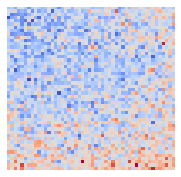

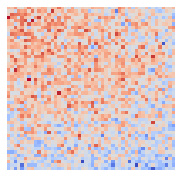

100 19.592315673828125
200 21.118162155151367
300 22.373117446899414
400 23.477012634277344
500 24.09002685546875
600 24.571081161499023
700 25.402687072753906
800 25.911582946777344
900 26.60618019104004
1000 26.924474716186523


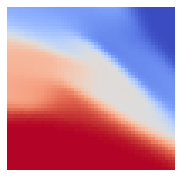

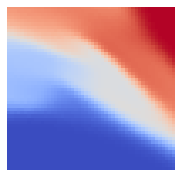

1100 27.186992645263672
1200 27.52494239807129
1300 27.46213722229004
1400 27.80244255065918
1500 27.78940200805664
1600 28.22917366027832
1700 27.936262130737305
1800 27.8898868560791
1900 28.173025131225586
2000 28.403867721557617


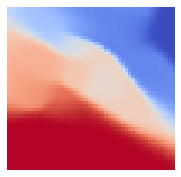

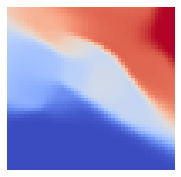

2100 28.29599380493164
2200 28.505889892578125
2300 28.20315933227539
2400 28.324617385864258
2500 28.31671714782715
2600 28.690032958984375
2700 28.344465255737305
2800 28.752580642700195
2900 28.473499298095703
3000 28.72313117980957


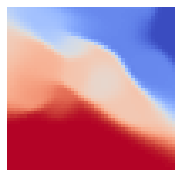

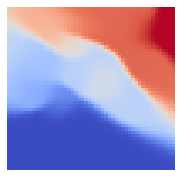

3100 28.28713035583496
3200 28.510578155517578
3300 28.934423446655273
3400 28.334718704223633
3500 28.574003219604492
3600 28.371320724487305
3700 28.82131576538086
3800 28.941829681396484
3900 28.40447425842285
4000 28.967161178588867


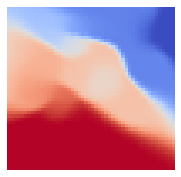

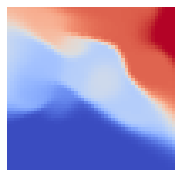

4100 28.399070739746094
4200 28.988929748535156
4300 28.520767211914062
4400 28.482980728149414
4500 28.765953063964844
4600 28.80316162109375
4700 28.386924743652344
4800 28.06217384338379
4900 28.336936950683594
5000 28.4323673248291


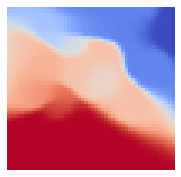

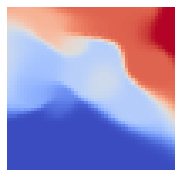

5100 28.975814819335938
5200 29.011770248413086
5300 28.9587345123291
5400 28.53232192993164
5500 28.444995880126953
5600 28.910680770874023
5700 28.54390525817871
5800 28.763545989990234
5900 28.42720603942871
6000 28.776405334472656


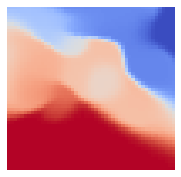

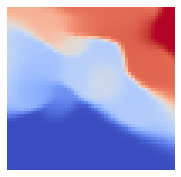

6100 28.592214584350586
6200 28.950990676879883
6300 28.612092971801758
6400 28.52965545654297
6500 28.76124382019043
6600 28.898555755615234
6700 28.69049644470215
6800 28.529586791992188
6900 29.08285903930664
7000 29.192480087280273


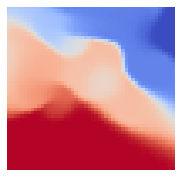

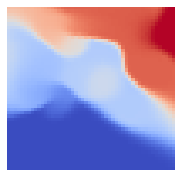

7100 28.56271743774414
7200 28.337627410888672
7300 28.9625186920166
7400 28.500804901123047
7500 28.912731170654297
7600 28.473161697387695
7700 28.81586265563965
7800 29.206220626831055
7900 29.054655075073242
8000 28.878021240234375


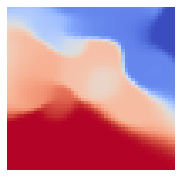

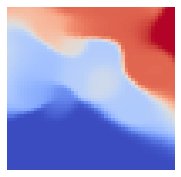

8100 29.342618942260742
8200 28.995080947875977
8300 28.75179672241211
8400 28.693986892700195
8500 28.709508895874023
8600 28.888221740722656
8700 29.217811584472656
8800 28.403104782104492
8900 28.485776901245117
9000 28.576980590820312


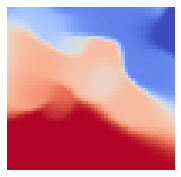

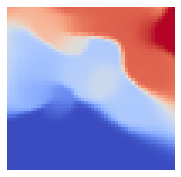

9100 28.70452117919922
9200 29.034862518310547
9300 28.840368270874023
9400 28.98026466369629
9500 29.091449737548828
9600 28.935415267944336
9700 29.17389678955078
9800 29.18051528930664


In [ ]:
torch.cuda.set_device(3)

def gauss(A,B,var):
    return torch.exp(-((A.unsqueeze(1) - B.unsqueeze(0))**2).mean(2)/(2*var))

for set_index in [0, 1, 2]:
    
    train_data = save_dataset[set_index]

    torch.manual_seed(0)
    np.random.seed(0)

    for set_inf in [0, 1, 2]:

        dim = 5

        E = encoder(input_dim = 2, out_dim = 1).cuda()

        optimizer_E = optim.Adam([
              {'params': E.parameters(), 'lr': 0.00001, 'betas': (0.5, 0.9)},
           ])

        elbo_curve = []
        pdf_curve = []

        data_dim = 2
        center_dim = 30

        for i in range(0, 20001):

            batch_data = torch.from_numpy(train_data[:5000]).float().cuda()

            # apply encoders

            encoded = E(batch_data)

            # add multiple "noise" or just one it is fine

            var_noise = 0.001
            var_samples = 0.001

            noise_encoded = encoded + torch.zeros((encoded.shape)).cuda().normal_()*np.sqrt(var_noise)

            combined = torch.cat((batch_data, encoded), 1)[:]
            noise_combined = combined + torch.zeros((combined.shape)).cuda().normal_()*np.sqrt(var_noise)

            pxy = torch.exp(-((combined.unsqueeze(1) - noise_combined.unsqueeze(0))**2).sum(-1)/(2*0.001)).mean(0)
            py = torch.exp(-((encoded.unsqueeze(1) - noise_combined[:, -1:].unsqueeze(0))**2).sum(-1)/(2*0.001)).mean(0)
            px = torch.exp(-((batch_data.unsqueeze(1) - noise_combined[:, :-1].unsqueeze(0))**2).sum(-1)/(2*0.001)).mean(0)

            pxy = pxy*(1/(2*np.pi*0.001)**(3/2))
            py = py*(1/(2*np.pi*0.001)**(1/2))
            px = px*(1/(2*np.pi*0.001)**(2/2))

        #     pdf_error = (pxy/py).mean()

            if set_inf == 0:
                pdf_error = (pxy/py).mean()

            if set_inf == 1:
                pdf_error =  torch.log(pxy/py).mean()

            if set_inf == 2:
                pdf_error = (pxy/(px*py)).mean()

            (-pdf_error).backward()
            pdf_curve.append([(pxy/py).mean().item(), torch.log(pxy/(px*py)).mean().item(), (pxy/(px*py)).mean().item()])

            optimizer_E.step()
            optimizer_E.zero_grad()

            if i % 100 == 0:
                print(i, pdf_error.item())

                if i%1000 == 0:
                    output_mean = 0

                    grid_size = 50
                    x = np.linspace(0.0, 1, grid_size)
                    y = np.linspace(0.0, 1, grid_size)
                    X, Y = np.meshgrid(x, y)
                    grid_points = np.column_stack([X.flatten(), Y.flatten()])
                    grid_points = torch.from_numpy(grid_points)

                    for n in range(0, 100):

                        E.eval()
                        with torch.no_grad():
                            output = E(grid_points.cuda().float()).detach().cpu().numpy()
                        E.train() 

                        output_mean = (output_mean*n+output)/(n+1)

                    plt.figure(figsize=(3, 3))
                    heatmap_extent = [0, 1, 0, 1]


                    plt.imshow(output_mean.reshape(-1).reshape(50, 50), cmap='coolwarm', extent=[0, 1, 0, 1], origin='lower', aspect='auto', zorder=1)
                    plt.axis('off')
                    plt.savefig('./max_dataset/MI_set_{0}_center_{1}.png'.format(set_index, set_inf), dpi=500, bbox_inches='tight')

                    plt.show()


                    plt.figure(figsize=(3, 3))
                    heatmap_extent = [0, 1, 0, 1]


                    plt.imshow(-output_mean.reshape(-1).reshape(50, 50), cmap='coolwarm', extent=[0, 1, 0, 1], origin='lower', aspect='auto', zorder=1)
                    plt.axis('off')
                    plt.savefig('./max_dataset/MI_set_{0}_center_{1}_negative.png'.format(set_index, set_inf), dpi=500, bbox_inches='tight')

                    plt.show()
                    

                    
                    
        spectrum_kica, eigenvectors, U, S, V, measure_kica, measure_hsic = KICA_spectrum(batch_data.detach().cpu(), encoded.detach().cpu(), alpha=1)

        np.save('./max_dataset/measure_kica_{0}_figure_MI_{1}.npy'.format(set_index, set_inf), measure_kica)
        np.save('./max_dataset/measure_hsic_{0}_figure_MI_{1}.npy'.format(set_index, set_inf), measure_hsic)
        np.save('./max_dataset/pdf_array_{0}_MI_{1}.npy'.format(set_index, set_inf), np.array(pdf_curve))

In [ ]:
# !nvidia-smi

In [ ]:
# !kill -9 496030